In [577]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
import random
import pandas as pd

Primeiro verificar os dados

In [578]:
class_dict = pd.read_csv('data/class_dict.csv')
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [579]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [580]:
temp_img = cv2.imread('data/train/119_sat.jpg')
print(temp_img.shape)

(2448, 2448, 3)


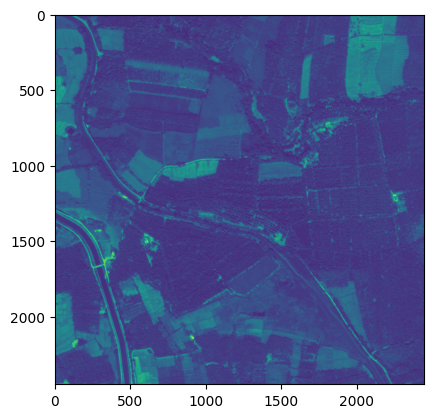

In [581]:
# o ultimo indice muda a banda da imagem (0,1,2)
plt.imshow(temp_img[:,:,2])

In [582]:
temp_mask = cv2.imread('data/train/119_mask.png')
print(temp_mask.shape)

(2448, 2448, 3)


In [583]:
labels, count = np.unique(temp_mask, return_counts=True)

In [584]:
print("Labels: ", labels)
print("Counts: ", count)

Labels:  [  0 255]
Counts:  [ 6100466 11877646]


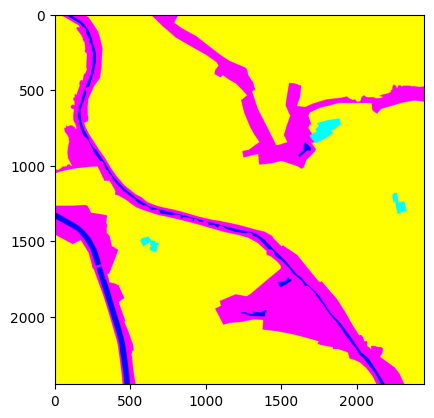

In [585]:
from matplotlib import colors
from matplotlib.colors import ListedColormap


# make a color map of fixed colors
cmap = colors.ListedColormap(['cyan', 'yellow', 'magenta', 'green', 'blue', 'white', 'black'])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap.N)
# # Display the first mask
plt.imshow(temp_mask)

num_labels = 7
mask = np.array(Image.open('data/train/119_mask.png'))
plt.imshow(mask, vmin=0, vmax=num_labels-1, cmap=cmap)
plt.show()

In [586]:
#amarelo - urban_land; red - water; cyan - barren

def RGBtoOneHot(rgb, colorDict):
  arr = np.zeros(rgb.shape[:2]) ## rgb shape: (h,w,3); arr shape: (h,w)
  #imprime a matriz rgb
  for label, color in enumerate(colorDict.keys()):
    color = np.array(color)
    if label < len(colorDict.keys()):
      #o print mostra o array de booleanos, onde a posicao que for igual a cor, vira true
      arr[np.all(rgb == color, axis=-1)] = label
  
  return arr

In [587]:
def onehot_to_rgb(oneHot, colorDict):
    oneHot = np.array(oneHot) ## ensuring numpy array; should be dims: (1, classes, height, width)
    oneHot = np.argmax(oneHot, axis=1) ## argmax along second dimension; reduces size to (1, height, width)
    output = np.zeros(oneHot.shape[1:3]+(3,)) ## size of height, width channel, + 3 for the rgb color space
    oneHot= np.transpose(oneHot, [1, 2, 0]) ## ensuring correct dimensions are compared 

    for index, color in enumerate(colorDict.keys()):
        if index < len(colorDict.keys()):
            output[np.all(oneHot== index, axis=-1)] = color

    return np.uint8(output)

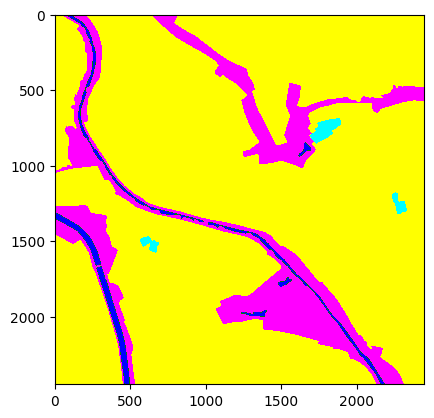

Labels:  [0. 1. 2. 4.]
Counts:  [  29401 4952892  902649  107762]


In [588]:
from matplotlib import colors
from matplotlib.colors import ListedColormap
from collections import namedtuple
# Define the color to label mapping
# name,r,g,b
# urban_land,0,255,255
# agriculture_land,255,255,0
# rangeland,255,0,255
# forest_land,0,255,0
# water,0,0,255
# barren_land,255,255,255
# unknown,0,0,0

Label = namedtuple('Label', ['name', 'color'])
labels = [
    Label('urban_land', (0, 255, 255)),
    Label('agriculture_land', (255, 255, 0)),
    Label('rangeland', (255, 0, 255)),
    Label('forest_land', (0, 255, 0)),
    Label('water', (0, 0, 255)),
    Label('barren_land', (255, 255, 255)),
    Label('unknown', (0, 0, 0))
]

color2label = {label.color: label for label in labels}

# make a color map of fixed colors
cmap = colors.ListedColormap(['cyan', 'yellow', 'magenta', 'green', 'blue', 'white', 'black'])
bounds=[0,1,2,3,4,5,6,7]
norm = colors.BoundaryNorm(bounds, cmap.N)

folder = 'data/train'

mask = np.array(Image.open('data/train/119_mask.png'))
one_hot_mask = RGBtoOneHot(mask, color2label)

num_labels = 7
plt.imshow(one_hot_mask, vmin=0, vmax=num_labels-1, cmap=cmap)
plt.show()

labels, count = np.unique(one_hot_mask, return_counts=True)

print("Labels: ", labels)
print("Counts: ", count)

In [589]:
import imageio
# Save the one-hot encoded array as a PNG file
imageio.imwrite('one_hot_encoded.png', one_hot_mask.astype(np.uint8))

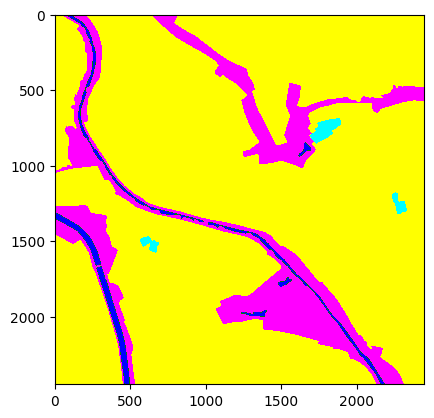

Labels:  [0 1 2 4]
Counts:  [  29401 4952892  902649  107762]


In [593]:
mask = np.array(Image.open('one_hot_encoded.png'))
num_labels = 7
plt.imshow(mask, vmin=0, vmax=num_labels-1, cmap=cmap)
plt.show()

labels, count = np.unique(mask, return_counts=True)

print("Labels: ", labels)
print("Counts: ", count)

In [590]:

one_hot_mask.shape #(2448, 2448)

# should be dims: (1, classes, height, width)

one_hot_mask = one_hot_mask.reshape((1, 2448, 2448))
one_hot_mask.shape

one_hot_mask = tf.keras.utils.to_categorical(one_hot_mask, num_classes=7)

one_hot_mask.shape #(1, 2448, 2448, 7)

#change the shape to (1, 7, 2448, 2448)

one_hot_mask = np.moveaxis(one_hot_mask, -1, 1)
one_hot_mask.shape #(1, 7, 2448, 2448)



(1, 7, 2448, 2448)

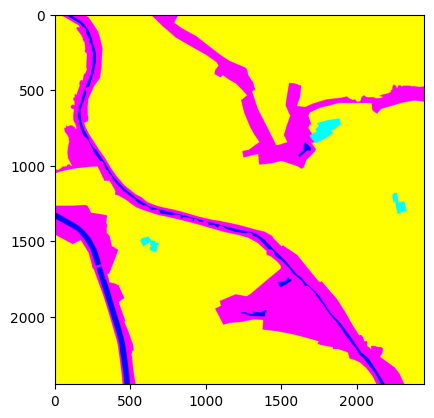

In [591]:


# transforma a mask one hot em rgb
rgb_mask = onehot_to_rgb(one_hot_mask, color2label)

# Display the first mask
plt.imshow(rgb_mask)

Entendido como faz para transformar uma imagem para one hot, precisamos fazer para todas. Pois precisamos categorizá-las

In [594]:
Label = namedtuple('Label', ['name', 'color'])
labels = [
    Label('urban_land', (0, 255, 255)),
    Label('agriculture_land', (255, 255, 0)),
    Label('rangeland', (255, 0, 255)),
    Label('forest_land', (0, 255, 0)),
    Label('water', (0, 0, 255)),
    Label('barren_land', (255, 255, 255)),
    Label('unknown', (0, 0, 0))
]

color2label = {label.color: label for label in labels}

#se não existir a pasta "data/masks_encoded", cria a pasta
if not os.path.exists('data/masks_encoded'):
    os.makedirs('data/masks_encoded')
    
def encode_masks(folder):
    for file in os.listdir(folder):
        if file.endswith('.png'):
            mask = np.array(Image.open(os.path.join(folder, file)))
            one_hot_mask = RGBtoOneHot(mask, color2label)
            imageio.imwrite(os.path.join('data/masks_encoded', file), one_hot_mask.astype(np.uint8))
    

In [595]:
encode_masks('data/train')